In [80]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists
import time
import pandas as pd
from scipy import signal
from scipy.fft import rfft, rfftfreq
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn import neighbors
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

#for balancing
# !pip install imblearn
from imblearn.under_sampling import RandomUnderSampler

%matplotlib inline

In [64]:
def load_one_patient(filename_x, filename_y):
    arr = np.load(filename_x)
    arrlabels = np.load(filename_y)
    return arr, arrlabels
    

In [65]:
def make_frame(arr, arrlabels):
    df = pd.DataFrame(index=range(arr.shape[0]),columns=range(arr.shape[1]))
    for i in range(0, arr.shape[0]):
        for j in range(0, arr.shape[1]):
            df.at[i, j] = pd.Series(arr[i][j])
    df['Labels'] = pd.Series(arrlabels)
    return df

In [66]:
def make_frame_testingdata(arr):
    df = pd.DataFrame(index=range(arr.shape[0]),columns=range(arr.shape[1]))
    for i in range(0, arr.shape[0]):
        for j in range(0, arr.shape[1]):
            df.at[i, j] = pd.Series(arr[i][j])
    return df




In [67]:
def create_features(df, row_idx, ch_name):
    new_features = []
    sample_series = df.iloc[row_idx, ch_name]
    #first filter the signal and reduce power noise - i use a notch filter
    b, a = signal.iirnotch(50, 30, 100)
    filtered_signal = signal.lfilter(b, a, sample_series.values)

    #time-domain analysis
    #mean amplitude
    mean_amplitude = np.mean(filtered_signal)
    new_features.append(mean_amplitude)
    #median amplitude
    median_amplitude = np.median(filtered_signal)
    new_features.append(median_amplitude)
    #std deviation
    std_amplitude = np.std(filtered_signal)
    new_features.append(std_amplitude)
    #Shannon entropy
    hist, bin_edges = np.histogram(filtered_signal, bins=10, density=True)
    entropy = -np.sum(hist * np.log2(hist + 1e-10))
    new_features.append(entropy)
    #signal power
    signal_power = np.mean(np.square(filtered_signal))
    new_features.append(signal_power)
    #signal energy
    signal_energy = np.sum(np.square(filtered_signal))
    new_features.append(signal_energy)

    #temporal features
    autocorr = np.correlate(filtered_signal, filtered_signal, mode='full')
    autocorr_value = autocorr[len(autocorr)//2]
    new_features.append(autocorr_value)


    #frequency-domain analysis 
    frequencies = rfftfreq(len(filtered_signal), 1/100)
    #band pass filter
    #frequencies = mne.filter.notch_filter(frequencies, sfreq = 100, l_freq = 1., h_freq = 40.)
    magnitudes = np.abs(rfft(filtered_signal))
    #dominant frequency
    index = np.argmax(magnitudes)
    dominant_frequency = frequencies[index]
    new_features.append(dominant_frequency)
    #rms_mean/ frequency that has the most power in power spectral density using mean
    f_welch, psd_mean = signal.welch(filtered_signal, 100)
    rms_mean = np.sqrt(psd_mean.max())
    new_features.append(rms_mean)
    #rms_mean/ frequency that has the most power in power spectral density using mean
    f_welch, psd_med = signal.welch(filtered_signal, 100, average='median')
    rms_med = np.sqrt(psd_med.max())
    new_features.append(rms_med)
    #spectral entropy
    normalized_psd = psd_mean / np.sum(psd_mean)
    hist, bin_edges = np.histogram(normalized_psd, bins=10, density=True)
    spec_entropy = -np.sum(hist * np.log2(hist + 1e-10))
    new_features.append(spec_entropy)
    
    
    return new_features


In [68]:
def populate_features(df, rowidx, col_name, features):
    df.loc[rowidx, col_name + '_meanAmp'] = features[0]
    df.loc[rowidx, col_name + '_medianAmp'] = features[1]
    df.loc[rowidx, col_name + '_stdAmp'] = features[2]
    df.loc[rowidx, col_name + '_timeEntropy'] = features[3]
    df.loc[rowidx, col_name + '_power'] = features[4]
    df.loc[rowidx, col_name + '_energy'] = features[5]
    df.loc[rowidx, col_name + '_autocorr'] = features[6]
    df.loc[rowidx, col_name + '_dominantFreq'] = features[7]
    df.loc[rowidx, col_name + '_rmsMean'] = features[8]
    df.loc[rowidx, col_name + '_rmsMedian'] = features[9]
    df.loc[rowidx, col_name + '_specEntropy'] = features[10]

In [69]:
def add_features(df, mode=True):
    appended_df = df.copy()
    columns = list(appended_df)
    if (mode):
        bound = len(columns)-1
    else:
        bound = len(columns)
    for column in columns[0:bound]:
        for index, row in appended_df.iterrows():
            features = create_features(appended_df, index, column)
            populate_features(appended_df, index, str(column), features)
    for column in range(6):
        appended_df[str(column) + "_rollingMean"] = appended_df[str(column) + "_meanAmp"].rolling(window=10, min_periods = 1).mean()
    return appended_df


In [70]:
def make_training_dataframe():
    start_time = time.time()
    big_df = pd.DataFrame()
    for i in range(0, 5):
        for j in range(1,3):  
            if(exists('p0' + str(i) + '_n' + str(j) + '_NEW_X.npy')):
                arr, arrlabels = load_one_patient('p0' + str(i) + '_n' + str(j) + '_NEW_X.npy', 
                                                  "p0" + str(i) + "_n" + str(j) + "_NEW_y.npy")
                df = make_frame(arr, arrlabels)
                big_df = pd.concat([big_df, df], ignore_index=True)
    mask = big_df['Labels'] == (0)
    big_df = big_df[~mask]
    
    #balancing
    big_df_labels = big_df['Labels']
    big_df_features = big_df.drop(columns = "Labels")
    undersampler = RandomUnderSampler(sampling_strategy='auto')
    big_df_features, big_df_labels = undersampler.fit_resample(big_df_features, big_df_labels)
    big_df_features['Labels'] = big_df_labels
    big_df = big_df_features
    
    big_df = big_df.reset_index()
    big_df = big_df.drop('index', axis = 1)
    
    print(big_df)

    new_df = add_features(big_df)
    
    #new_df
    
    print("--- %s seconds ---" % (time.time() - start_time))
    return new_df

#new_df = make_training_dataframe()
#new_df.to_csv("training_dataframe.csv")

In [71]:
def get_trained_model(filename):
    df = pd.read_csv(filename)
    y_data = df['Labels']
    X_data = df.drop(columns='Labels').drop(df.columns[0:7], axis=1)
    features25 = ['0_timeEntropy', 
                  '0_rmsMedian',
                  '0_stdAmp',
                  '2_timeEntropy',
                  '2_rmsMean',
                  '0_rmsMean',
                  '2_stdAmp',
                  '2_specEntropy',
                  '4_medianAmp',
                  '1_timeEntropy',
                  '2_rmsMedian',
                  '4_meanAmp',
                  '1_rmsMedian',
                  '1_stdAmp',
                  '1_rmsMean',
                  '5_autocorr',
                  '4_rollingMean',
                  '1_specEntropy',
                  '2_dominantFreq',
                  '0_specEntropy',
                  '5_medianAmp',
                  '5_power',
                  '5_meanAmp',
                  '5_rollingMean',
                  '2_autocorr']
    X_data_25 = X_data.loc[:, X_data.columns.isin(features25)]
    
    param_dist = {
        'max_depth': [None] + [*range(1,25)],
        'min_samples_leaf': range(1,25)
    }

    #Random_state set for reproducability, remove prior to final model training
    #Modify n_iter depending on time it takes to train model
    rand = RandomizedSearchCV(RandomForestClassifier(), param_dist, cv=10, scoring='accuracy', n_iter = 10, random_state=1)
    rand.fit(X_data_25,y_data)
    #print(rand.best_score_)
    
    model = rand.best_estimator_
    return model


In [72]:
def testing_function(filename_X):
    arr = np.load(filename_X)
    df = make_frame_testingdata(arr)
    #print(df)
    df_with_features = add_features(df, mode = False)
    X_data = df_with_features.drop(df.columns[0:7], axis=1)
    features25 = ['0_timeEntropy', 
                  '0_rmsMedian',
                  '0_stdAmp',
                  '2_timeEntropy',
                  '2_rmsMean',
                  '0_rmsMean',
                  '2_stdAmp',
                  '2_specEntropy',
                  '4_medianAmp',
                  '1_timeEntropy',
                  '2_rmsMedian',
                  '4_meanAmp',
                  '1_rmsMedian',
                  '1_stdAmp',
                  '1_rmsMean',
                  '5_autocorr',
                  '4_rollingMean',
                  '1_specEntropy',
                  '2_dominantFreq',
                  '0_specEntropy',
                  '5_medianAmp',
                  '5_power',
                  '5_meanAmp',
                  '5_rollingMean',
                  '2_autocorr']
    X_data_25 = X_data.loc[:, X_data.columns.isin(features25)]
    
    trained_model = get_trained_model("training_dataframe.csv")
    predictions = trained_model.predict(X_data_25)

    
    return predictions
    

In [85]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    title = 'Confusion matrix'
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized ' + title

    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt=".2f", cmap=cmap, linewidths=.5, square=True,
                xticklabels=classes, yticklabels=classes, cbar_kws={"shrink": 0.8})

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(title)
    plt.show()


0.896028880866426


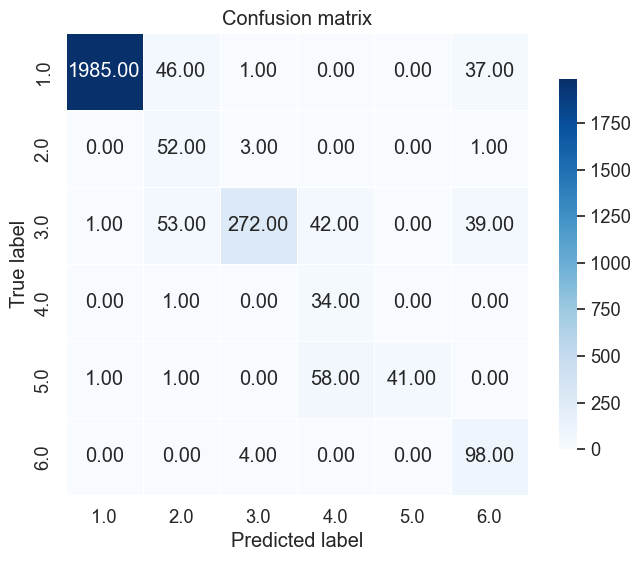

In [86]:
from sklearn.utils.multiclass import unique_labels

def final_driver(filename_X, filename_y):
    predictions = testing_function(filename_X)
    y_test = pd.Series(np.load(filename_y))
    accuracy = metrics.accuracy_score(y_test, predictions)
    print(accuracy)

    y_true = np.array(y_test)
    y_pred = np.array(predictions)
    classes = unique_labels(y_true, y_pred)
    plot_confusion_matrix(y_true, y_pred, classes)
    

final_driver('p06_n1_NEW_X.npy', 'p06_n1_NEW_y.npy' )

In [87]:
predictions_a = testing_function('eval_a_NEW_X.npy')
predictions_b = testing_function('eval_b_NEW_X.npy')


Text(0.5, 1.0, 'Distribution of Sleep Stage Category Prediction, A')

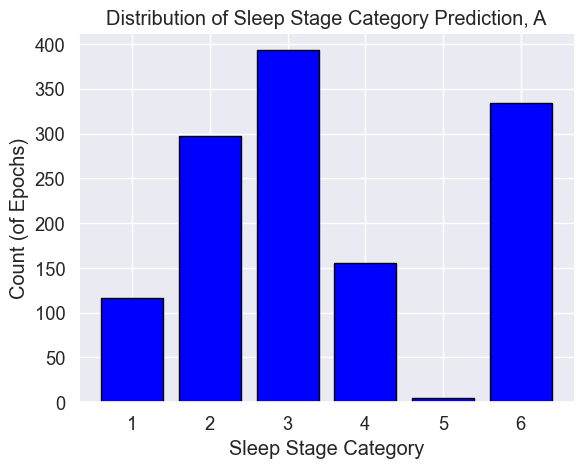

In [100]:
unique_values, frequencies = np.unique(predictions_a, return_counts=True)
# Create a bar plot
plt.bar(unique_values, frequencies, color='blue', edgecolor='black')
plt.xlabel("Sleep Stage Category")
plt.ylabel("Count (of Epochs)")
plt.title("Distribution of Sleep Stage Category Prediction, A")

Text(0.5, 1.0, 'Distribution of Sleep Stage Category Prediction, B')

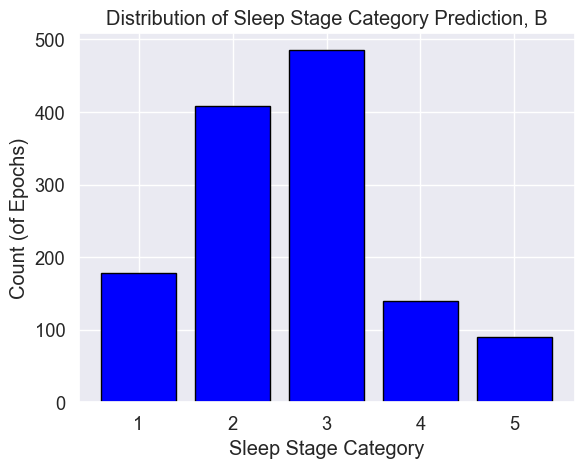

In [103]:
unique_values, frequencies = np.unique(predictions_b, return_counts=True)
# Create a bar plot
plt.bar(unique_values, frequencies, color='blue', edgecolor='black')
plt.xlabel("Sleep Stage Category")
plt.ylabel("Count (of Epochs)")
plt.title("Distribution of Sleep Stage Category Prediction, B")

In [102]:
np.save('eval_a_NEW_y.npy', predictions_a)
np.save('eval_b_NEW_y.npy', predictions_b)